In [87]:
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
from matplotlib import pyplot as plt
from pathlib import Path

from hydrosystem.evt_analysis import gumbel_analysis

path_to_data_formatted = Path("../src/data/formatted")
path_to_data_processed = Path("../src/data/processed")

from hydrosystem import trend_analysis

variables_with_units = {
    "epot": "Potential Evapotranspiration (mm/day)",
    "p": "Precipitation (mm/day)",
    "q": "Discharge (mm/day)",
    "t": "Temperature (°C)",
}
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

In [88]:
timeseries = pd.read_csv(path_to_data_formatted / "timeseries_raw.csv")
timeseries["date"] = pd.to_datetime(timeseries["date"])
timeseries["month"] = timeseries["date"].dt.month
timeseries["year"] = timeseries["date"].dt.year

timeseries_corrected = pd.read_csv(path_to_data_processed / "timeseries_corrected.csv")
timeseries_corrected["date"] = pd.to_datetime(timeseries_corrected["date"])
timeseries_corrected["month"] = timeseries_corrected["date"].dt.month
timeseries_corrected["year"] = timeseries_corrected["date"].dt.year

C:\Users\MUNRAS\AppData\Local\Temp\ipykernel_6480\1388112249.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


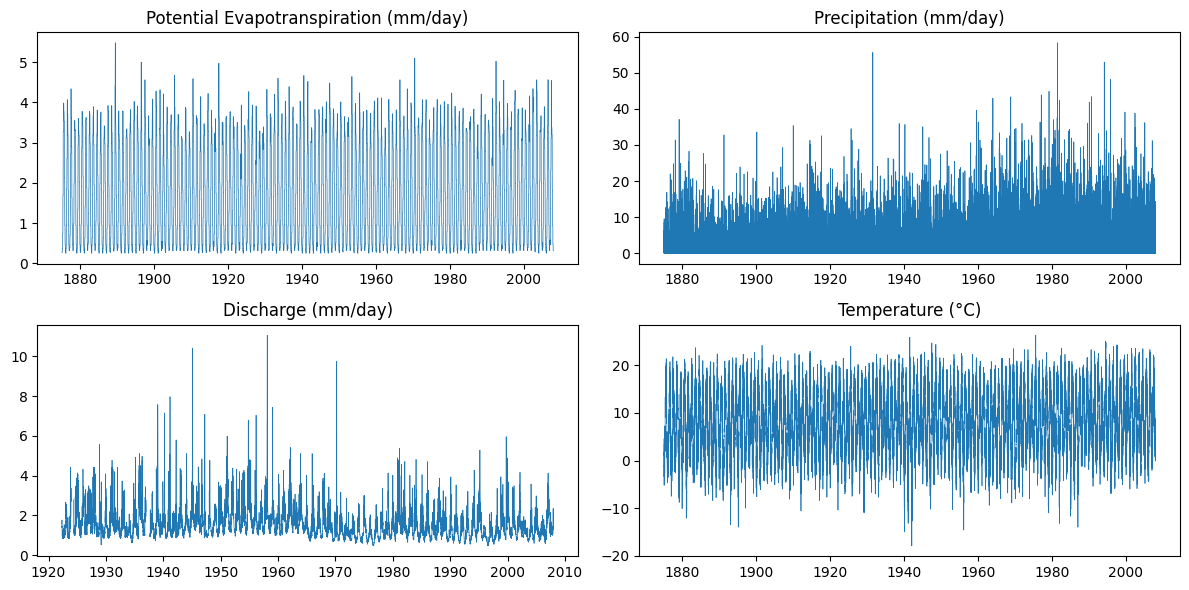

In [89]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12,6))
for k, ax in zip(variables_with_units, axs.flat):
    ax.plot(timeseries["date"], timeseries[k], label=k, lw=0.5)
    ax.set_title(variables_with_units[k])
fig.tight_layout()
fig.savefig("plots/raw_timeseries.png")
fig.show()

C:\Users\MUNRAS\AppData\Local\Temp\ipykernel_6480\2223787028.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


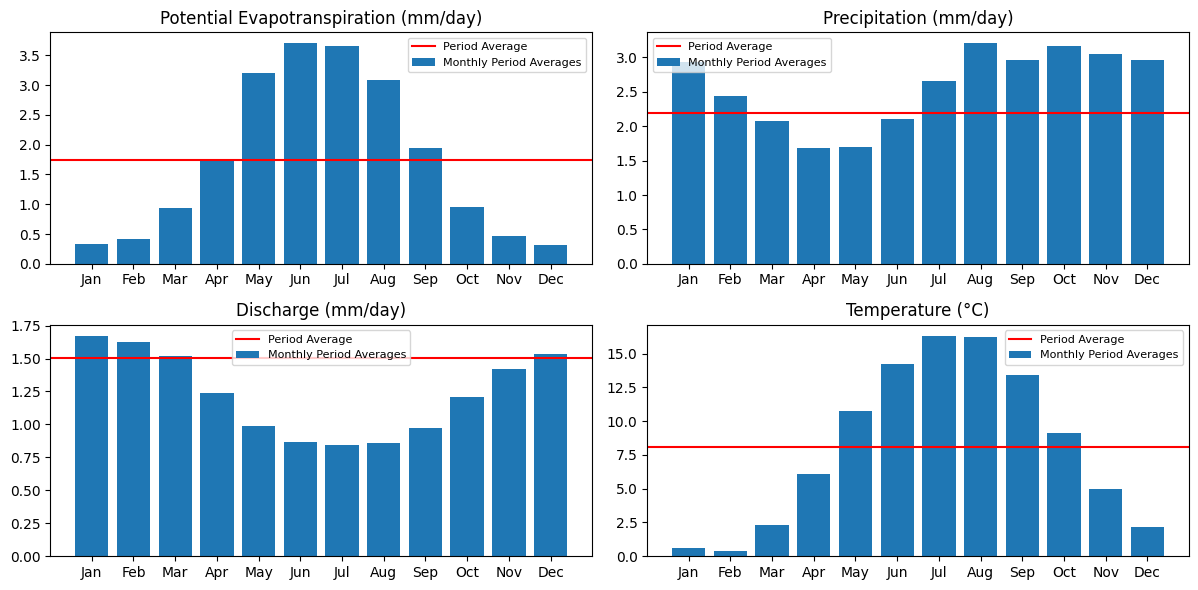

In [90]:
per_month_averages = timeseries_corrected.groupby("month").agg({
    "p": "mean",
    "t": "mean",
    "epot": "mean",
    "q": "mean"
})
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12,6))
for k, ax in zip(variables_with_units, axs.flat):
    ax.bar([months[i] for i in range(12)], per_month_averages[k], label="Monthly Period Averages")
    ax.axhline(y=timeseries[k].mean(), color="r", label="Period Average")
    ax.set_title(variables_with_units[k])
    ax.legend(fontsize=8)
fig.tight_layout()
fig.savefig("plots/monthly_averages.png")
fig.show()

In [91]:
per_month_per_year_averages = timeseries_corrected.groupby(["month", "year"]).agg({
    "epot": "mean",
    "p": "mean",
    "q": "mean",
    "t": "mean",
})
per_year_averages = timeseries_corrected.groupby("year").agg({
    "epot": "mean",
    "p": "mean",
    "q": "mean",
    "t": "mean",
})

In [92]:
per_year_timeseries = {
    k: np.asarray(per_year_averages[k])
    for k in variables_with_units
}
per_month_per_year_timeseries = {
    month: {
        k: np.asarray(per_month_per_year_averages.loc[month,k])
        for k in variables_with_units
    }
    for month in range(1,13)
}
trend_analysis_overall = jax.tree.map(trend_analysis.mann_kendall_analysis, per_year_timeseries)
trend_analysis_per_month = jax.tree.map(trend_analysis.mann_kendall_analysis, per_month_per_year_timeseries)

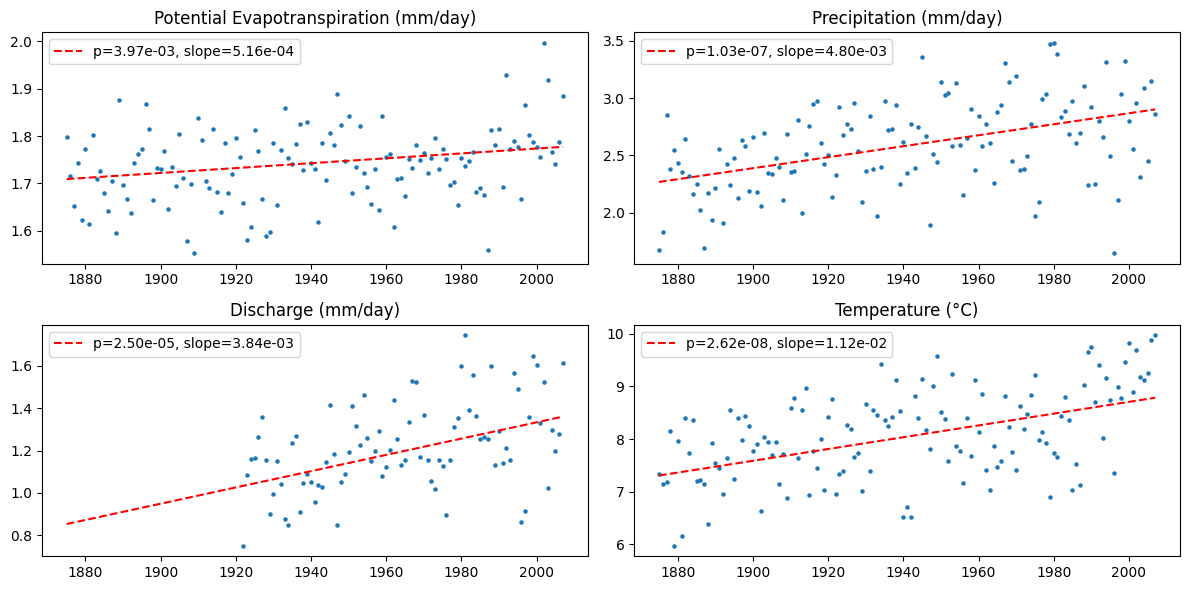

In [93]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12,6))
for k, ax in zip(variables_with_units, axs.flat):
    trend_analysis_overall[k].plot(per_year_averages.index, ax=ax)
    ax.set_title(variables_with_units[k])
    ax.legend()
fig.tight_layout()
fig.savefig("plots/trend_analysis_overall.png")

In [94]:
monthly_slope = pd.DataFrame(
    jax.tree.map(lambda x: x.slope, trend_analysis_per_month, is_leaf=lambda x: isinstance(x, trend_analysis.MannKendallAnalysisResults))
).T
monthly_slope["Month"] = months
monthly_slope[["Month", "epot", "p", "q", "t"]].rename(variables_with_units, axis=1).to_csv("tables/monthly_slope.csv", index=False)

monthly_p_value = pd.DataFrame(
    jax.tree.map(lambda x: x.p, trend_analysis_per_month, is_leaf=lambda x: isinstance(x, trend_analysis.MannKendallAnalysisResults))
).T
monthly_p_value["Month"] = months
monthly_p_value[["Month", "epot", "p", "q", "t"]].rename(variables_with_units, axis=1).to_csv("tables/monthly_p_value.csv", index=False)

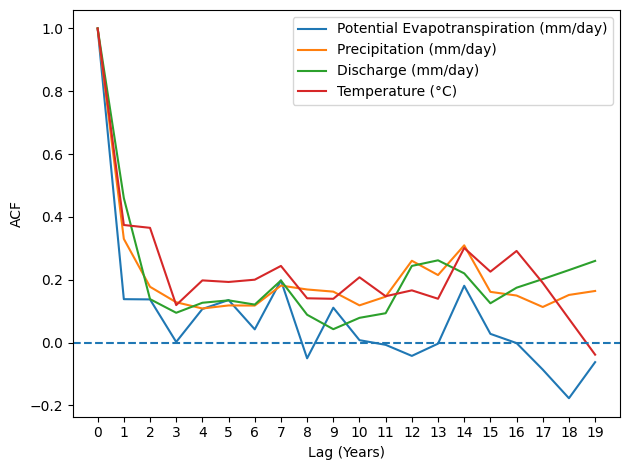

In [95]:
acf = {
    col: [pd.Series(per_year_timeseries[col]).autocorr(lag=k) for k in range(20)]
    for col in variables_with_units
}
fig, ax = plt.subplots()
for col in acf:
    ax.plot(acf[col], label=variables_with_units[col])
ax.axhline(y=0, linestyle="--")
ax.set_xticks(range(20))
ax.legend()
ax.set_xlabel("Lag (Years)")
ax.set_ylabel("ACF")
fig.tight_layout()
fig.savefig("plots/acf.png")

In [9]:
from hydrosystem import evt_analysis

In [29]:
from importlib import reload
reload(evt_analysis)

<module 'hydrosystem.evt_analysis' from 'C:\\Users\\MUNRAS\\PycharmProjects\\NAM\\src\\hydrosystem\\evt_analysis\\__init__.py'>

In [96]:
reference_period = timeseries_corrected[
    np.logical_and(
        timeseries_corrected["year"] >= 1971,
        timeseries_corrected["year"] <= 2000
    )
]
reference_period_annual_maxima = reference_period.groupby("year").agg({
    "p": "max",
    "q": "max",
    "t": "max"
}).to_dict("series")
reference_period_annual_minima = reference_period.groupby("year").agg({
    "q": "min",
    "t": "min",
}).to_dict("series")

maxima_fits = jax.tree.map(lambda x: evt_analysis.gumbel_analysis(x, jnp.array([50, 100, 200])), reference_period_annual_maxima)
minima_fits = jax.tree.map(lambda x: evt_analysis.gumbel_analysis(x, jnp.array([50, 100, 200]), minima=True), reference_period_annual_minima)

In [97]:
list(reference_period_annual_maxima.keys())

['p', 'q', 't']

In [98]:
reference_period_annual_maxima.keys()

dict_keys(['p', 'q', 't'])

In [86]:
maxima_fits.keys()

dict_keys(['p', 'q', 't'])

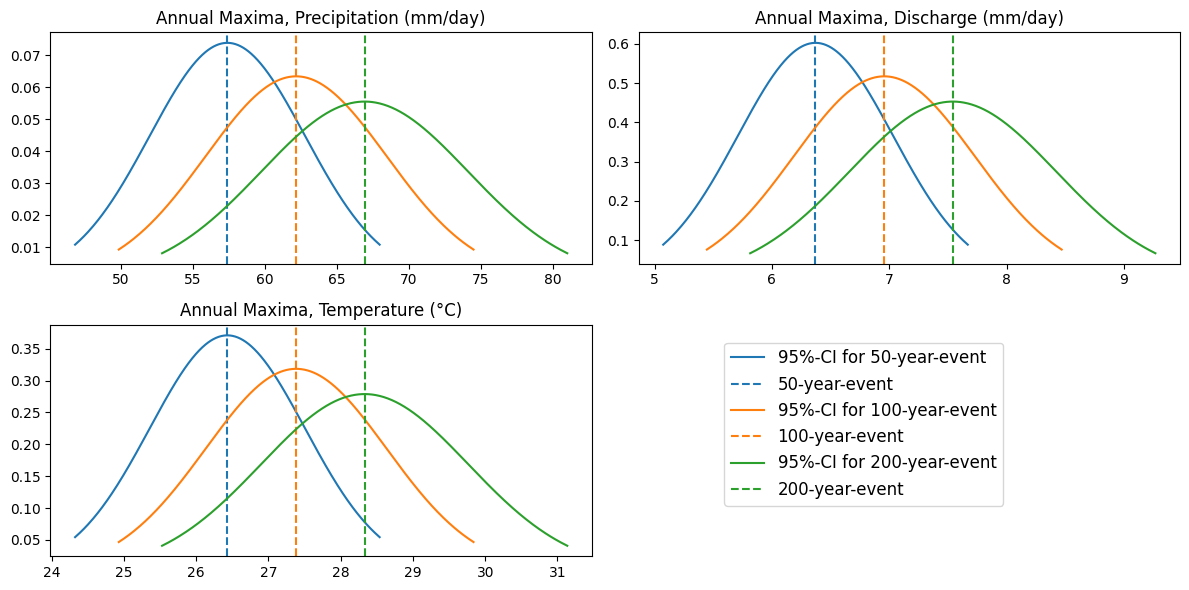

In [102]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12,6))
for k, ax in zip(maxima_fits, axs.flat):
    maxima_fits[k].plot(ax=ax)
    ax.set_title(f"Annual Maxima, {variables_with_units[k]}")
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles=handles,
    labels=labels,
    loc='center',
    bbox_to_anchor=axs.flat[-1].get_position(fig),
    frameon=True,
    fontsize=12
)
axs.flat[-1].set_visible(False)
fig.tight_layout()
fig.savefig("plots/evt_maxima.png")

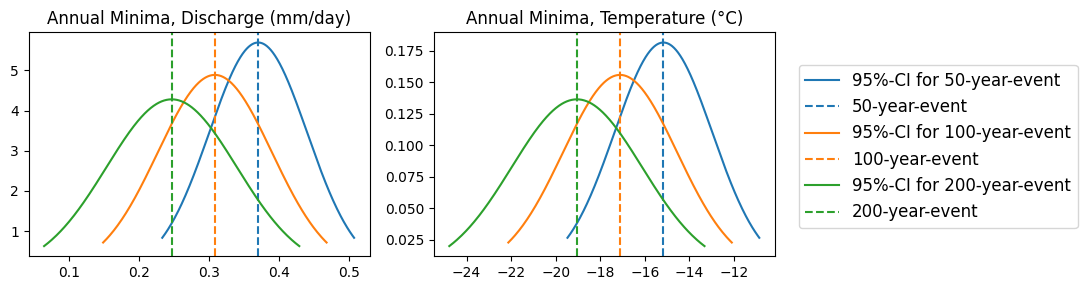

In [101]:
fig, axs = plt.subplots(ncols=3, figsize=(12,3))
for k, ax in zip(minima_fits, axs.flat):
    minima_fits[k].plot(ax=ax)
    ax.set_title(f"Annual Minima, {variables_with_units[k]}")
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles=handles,
    labels=labels,
    loc='center',
    bbox_to_anchor=axs.flat[-1].get_position(fig),
    frameon=True,
    fontsize=12
)
axs.flat[-1].set_visible(False)
fig.tight_layout()
fig.savefig("plots/evt_minima.png")